# Install OpenCV

In [1]:
!pip install opencv-python
!pip install pytesseract
!pip install matplotlib

In [2]:
import cv2
import os
import re
import numpy as np
import pytesseract
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pytesseract import Output
from PIL import Image, ImageOps,  ImageDraw
import colorsys
from datetime import datetime, timedelta
from IPython.display import clear_output, display
from matplotlib.colors import rgb_to_hsv
from scipy.spatial.distance import euclidean
from skimage.measure import label, regionprops
import matplotlib.colors as colors
import matplotlib.dates as mdates

# Define ROI for OCR

In [3]:
# Define the path to the directory containing the images
image_directory = 'Thermal Placement 1'
image_files = os.listdir(image_directory)

# Define your ROI coordinates (x, y, w, h)
roi_hottest = (279, 43, 39, 20)
roi_coldest = (278, 175, 39, 20)

# Apply interpolation & replace invalid value
We decided to use this as hottest temperature got better RMSE (Compare to the accurate one), even though coldest temperature'sRMSE is slightly higher than median function.  

**Int** 	  
MAE_Cold:	0.4705  
MAPE_Cold:	0.0229  
RMSE_Cold:	0.7965  
	
**Avg**	 
MAE_Cold:	0.4639   
MAPE_Cold:	0.0276  
RMSE_Cold:	0.7901  
	
**Int**   
MAE_Hot:	0.1946  
MAPE_Hot:	0.0071  
RMSE_Hot:	0.6068  
	
**Avg**	  
MAE_Hot:	0.8584  
MAPE_Hot:	0.0336  
RMSE_Hot:	1.8496   

In [4]:
def is_interval_close_to_10_minutes(time1, time2):
    """Check if the interval between two times is approximately 10 minutes."""
    interval = abs(time2 - time1)
    return timedelta(minutes=9, seconds=30) < interval < timedelta(minutes=10, seconds=30)

def clean_temperature(ocr_result):
    """Clean the OCR result to extract temperature."""
    cleaned_text = re.sub(r'[^\d.]+', '', ocr_result)
    if not cleaned_text or not re.match(r'^\d{1,2}\.\d$', cleaned_text):
        return 'Invalid'
    temp_value = float(cleaned_text)
    if 13.0 <= temp_value <= 35.0:
        return cleaned_text
    else:
        return 'Invalid'

def interpolate_temperatures(temps):
    """Interpolate 'Invalid' temperatures in a list of temperatures."""
    if not temps or all(temp == 'Invalid' for temp in temps):
        return temps  # Return as is if empty or all invalid
    
    # Convert all valid temperature strings to floats, keep 'Invalid' as is
    for i in range(len(temps)):
        if temps[i] != 'Invalid':
            temps[i] = float(temps[i])

    # Interpolate invalid values
    for i in range(len(temps)):
        if temps[i] == 'Invalid':
            # Find the nearest previous valid temperature
            prev_temp = None
            for j in range(i - 1, -1, -1):
                if temps[j] != 'Invalid':
                    prev_temp = temps[j]
                    break
            
            # Find the nearest next valid temperature
            next_temp = None
            for j in range(i + 1, len(temps)):
                if temps[j] != 'Invalid':
                    next_temp = temps[j]
                    break

            # Calculate the interpolated temperature
            if prev_temp is not None and next_temp is not None:
                temps[i] = (prev_temp + next_temp) / 2
            elif prev_temp is not None:
                temps[i] = prev_temp  # Use the previous temp if no next temp
            elif next_temp is not None:
                temps[i] = next_temp  # Use the next temp if no previous temp

    # Convert temperatures back to string format if necessary
    return [str(temp) if isinstance(temp, float) else temp for temp in temps]

all_results = []

for image_name in image_files:
    if image_name.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp')):
        base_name = os.path.splitext(image_name)[0]
        timestamp_str = base_name.split('_')[1]
        frame_datetime = datetime.strptime(timestamp_str, '%Y%m%d-%H%M%S')

        image_path = os.path.join(image_directory, image_name)
        image = Image.open(image_path)

        cropped_hottest = image.crop((roi_hottest[0], roi_hottest[1], roi_hottest[0] + roi_hottest[2], roi_hottest[1] + roi_hottest[3]))
        gray_hottest = ImageOps.grayscale(cropped_hottest)
        text_hottest = pytesseract.image_to_string(gray_hottest)
        
        cropped_coldest = image.crop((roi_coldest[0], roi_coldest[1], roi_coldest[0] + roi_coldest[2], roi_coldest[1] + roi_coldest[3]))
        gray_coldest = ImageOps.grayscale(cropped_coldest)
        text_coldest = pytesseract.image_to_string(gray_coldest)

        hottest_temp = clean_temperature(text_hottest)
        coldest_temp = clean_temperature(text_coldest)

        all_results.append((frame_datetime, hottest_temp, coldest_temp))

# Sort the results by datetime
sorted_results = sorted(all_results, key=lambda x: x[0])

# Apply filtering for ~10-minute intervals
filtered_results = []
for i in range(1, len(sorted_results)):
    if is_interval_close_to_10_minutes(sorted_results[i-1][0], sorted_results[i][0]):
        filtered_results.append(sorted_results[i-1])
if len(sorted_results) > 1 and is_interval_close_to_10_minutes(sorted_results[-2][0], sorted_results[-1][0]):
    filtered_results.append(sorted_results[-1])

# Separate temperatures and interpolate invalid values for filtered results
hottest_temps = [result[1] for result in filtered_results]
coldest_temps = [result[2] for result in filtered_results]
interpolated_hottest = interpolate_temperatures(hottest_temps)
interpolated_coldest = interpolate_temperatures(coldest_temps)

# Update filtered_results with interpolated temperatures
for i, _ in enumerate(filtered_results):
    filtered_results[i] = (filtered_results[i][0], interpolated_hottest[i], interpolated_coldest[i])

print(f"Total Results After Filtering and Interpolation: {len(filtered_results)}")
for result in filtered_results:
    frame_datetime = result[0].strftime('%Y-%m-%d %H:%M:%S')
    # Ensure temperatures are floats, then format to one decimal place
    hottest = float(result[1]) if result[1] != 'Invalid' else result[1]
    coldest = float(result[2]) if result[2] != 'Invalid' else result[2]
    
    hottest_str = f"{hottest:.1f}" if hottest != 'Invalid' else hottest
    coldest_str = f"{coldest:.1f}" if coldest != 'Invalid' else coldest
    
    print(f"{frame_datetime}: Hottest {hottest_str}, Coldest {coldest_str}")

Total Results After Filtering and Interpolation: 166
2024-03-26 11:14:30: Hottest 28.3, Coldest 17.0
2024-03-26 11:24:30: Hottest 28.4, Coldest 16.9
2024-03-26 11:34:30: Hottest 28.5, Coldest 16.9
2024-03-26 11:44:31: Hottest 28.4, Coldest 16.8
2024-03-26 11:54:31: Hottest 28.6, Coldest 17.6
2024-03-26 12:04:31: Hottest 28.9, Coldest 18.4
2024-03-26 12:14:31: Hottest 29.0, Coldest 17.2
2024-03-26 12:24:32: Hottest 29.2, Coldest 18.5
2024-03-26 12:34:32: Hottest 29.3, Coldest 17.2
2024-03-26 12:44:32: Hottest 29.5, Coldest 18.5
2024-03-26 12:54:33: Hottest 29.3, Coldest 19.8
2024-03-26 13:04:33: Hottest 29.2, Coldest 18.3
2024-03-26 13:14:33: Hottest 28.4, Coldest 17.6
2024-03-26 13:24:34: Hottest 28.0, Coldest 17.2
2024-03-26 13:34:34: Hottest 27.6, Coldest 16.8
2024-03-26 13:44:34: Hottest 30.4, Coldest 17.3
2024-03-26 13:54:35: Hottest 30.4, Coldest 16.8
2024-03-26 14:04:35: Hottest 30.4, Coldest 16.9
2024-03-26 14:14:35: Hottest 30.1, Coldest 16.9
2024-03-26 14:24:36: Hottest 29.1, 

# Data visualization

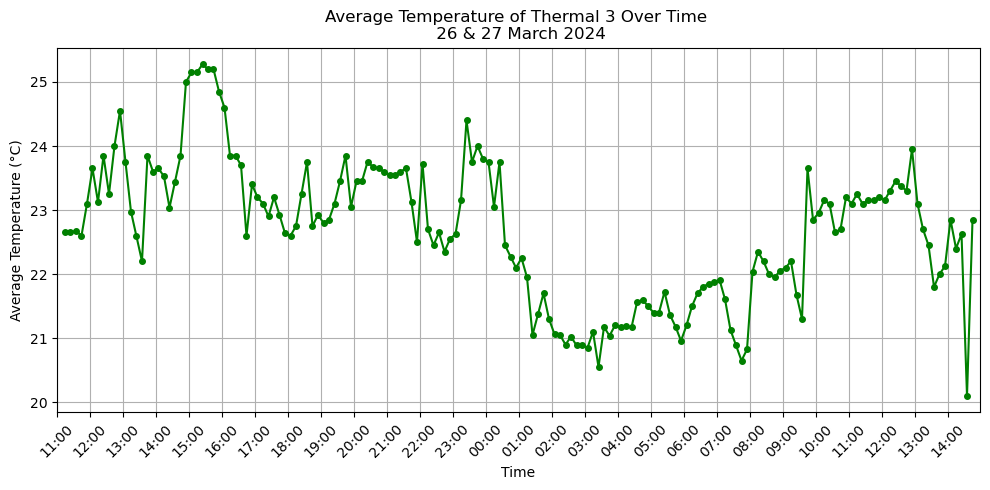

In [5]:
data = {
    'Datetime': [result[0] for result in filtered_results],
    'Hottest': [float(temp) if temp != 'Invalid' else None for temp in (result[1] for result in filtered_results)],
    'Coldest': [float(temp) if temp != 'Invalid' else None for temp in (result[2] for result in filtered_results)]
}
df = pd.DataFrame(data)

# Calculate the average temperature
df['Average'] = df[['Hottest', 'Coldest']].mean(axis=1)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(df['Datetime'], df['Average'], marker='o', linestyle='-', color='g', markersize=4)  # Smaller marker size
plt.title('Average Temperature of Thermal 3 Over Time \n 26 & 27 March 2024')
plt.xlabel('Time')
plt.ylabel('Average Temperature (°C)')
plt.grid(True)

# Set x-axis major ticks to hourly intervals
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=1))  # every hour
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))  # format datetime to show only time

# Explicitly set x-axis limits
start_date = pd.to_datetime('2024-03-26 11:00')
end_date = pd.to_datetime('2024-03-27 14:59')
plt.gca().set_xlim(start_date, end_date)

plt.xticks(rotation=45)  # Rotate date labels for better readability
plt.tight_layout()  # Adjust layout to make room for label rotation

# Show the plot
plt.show()

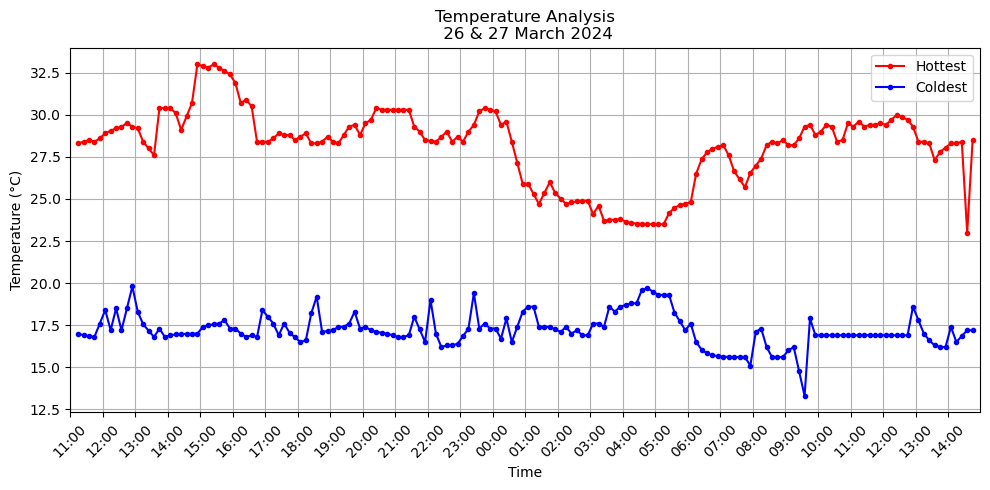

In [6]:
data = {
    'Datetime': [result[0] for result in filtered_results],
    'Hottest': [float(temp) if temp != 'Invalid' else None for temp in (result[1] for result in filtered_results)],
    'Coldest': [float(temp) if temp != 'Invalid' else None for temp in (result[2] for result in filtered_results)]
}
df = pd.DataFrame(data)

# Calculate the gap between hottest and coldest temperatures
# df['Temperature Gap'] = df['Hottest'] - df['Coldest']

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(df['Datetime'], df['Hottest'], marker='o', linestyle='-', color='r', markersize=3, label='Hottest')
plt.plot(df['Datetime'], df['Coldest'], marker='o', linestyle='-', color='b', markersize=3, label='Coldest')
# plt.plot(df['Datetime'], df['Temperature Gap'], marker='x', linestyle='--', color='r', markersize=4, label='Temp Gap')

plt.title('Temperature Analysis\n 26 & 27 March 2024')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.grid(True)

# Adding a legend to clarify the lines
plt.legend(loc='upper right')

# Set x-axis major ticks to hourly intervals
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=1))  # every hour
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))  # format datetime to show only time

# Explicitly set x-axis limits
start_date = pd.to_datetime('2024-03-26 11:00')
end_date = pd.to_datetime('2024-03-27 14:59')
plt.gca().set_xlim(start_date, end_date)

plt.xticks(rotation=45)  # Rotate date labels for better readability
plt.tight_layout()  # Adjust layout to make room for label rotation

# Show the plot
plt.show()

# Map the color

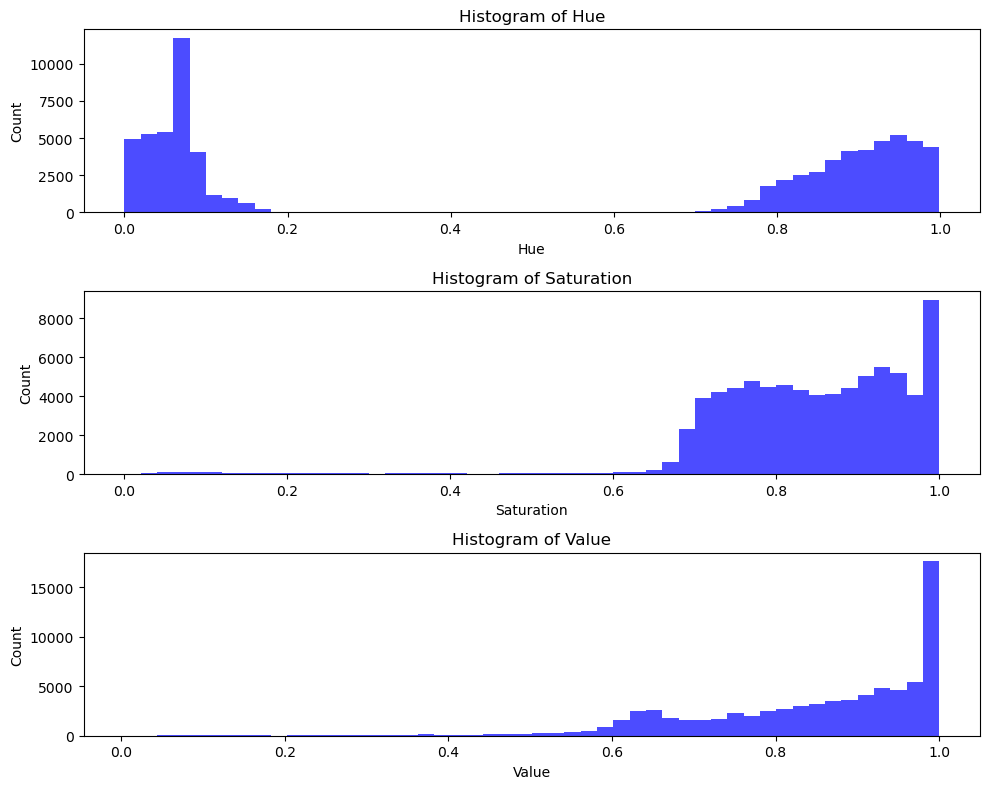

In [7]:
# Load the image and convert to HSV
img = Image.open('Thermal Placement 1/photo_20240327-113517.jpg')
pixels = np.array(img)
hsv_pixels = colors.rgb_to_hsv(pixels / 255.0)  # Convert RGB to HSV

# Flatten the image for easier analysis
hsv_pixels_flat = hsv_pixels.reshape(-1, 3)

# Plot histograms for Hue, Saturation, and Value
fig, axs = plt.subplots(3, 1, figsize=(10, 8))
titles = ['Hue', 'Saturation', 'Value']
for i, ax in enumerate(axs):
    ax.hist(hsv_pixels_flat[:, i], bins=50, color='blue', alpha=0.7)
    ax.set_title(f'Histogram of {titles[i]}')
    ax.set_xlabel(titles[i])
    ax.set_ylabel('Count')

plt.tight_layout()
plt.show()

In [8]:
# Load the image
img = Image.open('Thermal Placement 3/resized/photo_20240314-164517.jpg')
pixels = np.array(img)

# Function to categorize pixels
def categorize_pixel(hsv_pixel):
    hue, sat, val = hsv_pixel
    # Assuming dark colors for low temperatures
    if val < 0.2:
        return 'low'
    # Assuming red colors for highest temperatures
    elif hue < 0.1 and sat > 0.5 and val > 0.5:
        return 'high'
    # Define new ranges for 'below_mid' and 'above_mid' based on your specific needs
    # Below assumes hue ranges to distinguish between below_mid and above_mid
    elif hue < 0.3:  # Adjust the hue value to fit your data
        return 'below_mid'
    elif hue < 0.6:  # Adjust the hue value to fit your data
        return 'above_mid'
    else:
        return 'medium'

# Convert RGB to HSV for easier color segmentation
hsv_pixels = rgb_to_hsv(pixels / 255.0)  # Normalize the RGB values

# Categorize each pixel
categories = np.array([[categorize_pixel(pixel) for pixel in row] for row in hsv_pixels])

# Create an overlay image for visualizing the categorization
overlay_img = Image.new("RGB", img.size, (255, 255, 255, 0))
draw = ImageDraw.Draw(overlay_img)

# Draw rectangles based on category
for y, row in enumerate(categories):
    for x, category in enumerate(row):
        color = (255, 255, 255, 0)  # Default to transparent
        if category == 'low':
            color = (0, 0, 255, 255)  # Blue for low
        elif category == 'below_mid':
            color = (0, 255, 0, 255)  # Green for below mid
        elif category == 'medium':
            color = (255, 255, 0, 255)  # Yellow for medium
        elif category == 'above_mid':
            color = (255, 165, 0, 255)  # Orange for above mid
        elif category == 'high':
            color = (255, 0, 0, 255)  # Red for high
        draw.rectangle([x, y, x+1, y+1], fill=color)
        
# Combine the original image with the overlay
combined = Image.blend(img, overlay_img, alpha=0.5)

# Display the image
combined.show()

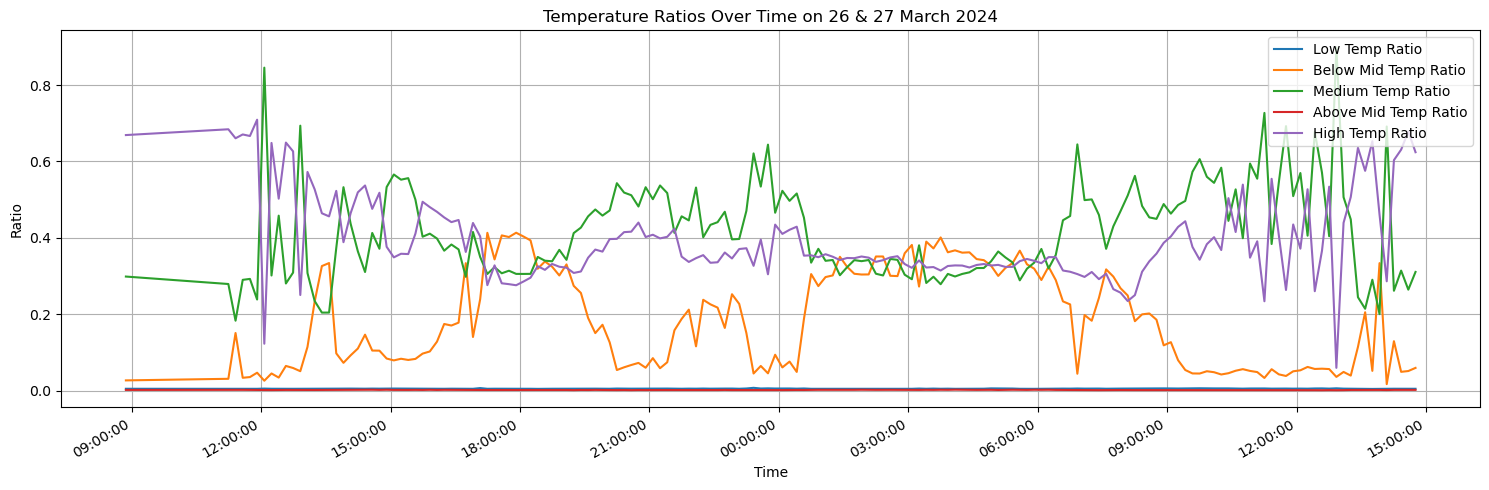

In [9]:
# Define your image directory and sort the files
image_directory = 'Thermal Placement 1'
image_files = sorted(os.listdir(image_directory))

# Regex pattern to match files of the format 'photo_YYYYMMDD-HHMMSS.jpg'
pattern = re.compile(r'^photo_\d{8}-\d{6}\.jpg$')

# Storage for ratios
ratios = {
    'timestamp': [],
    'low_ratio': [],
    'below_mid_ratio': [],
    'medium_ratio': [],
    'above_mid_ratio': [],
    'high_ratio': []
}

# Process each image, skipping files that do not match the expected pattern
for image_file in image_files:
    if not pattern.match(image_file):
        continue  # Skip processing this file

    # Extract timestamp from filename (format 'photo_YYYYMMDD-HHMMSS.jpg')
    timestamp = datetime.strptime(image_file, 'photo_%Y%m%d-%H%M%S.jpg')
    
    # Load the image
    img = Image.open(os.path.join(image_directory, image_file))
    pixels = np.array(img)

    # Convert RGB to HSV (your categorize_pixel function will be used here)
    hsv_pixels = rgb_to_hsv(pixels / 255.0)

    # Categorize each pixel (make sure your categorize_pixel function is correctly defined)
    categories = np.array([[categorize_pixel(pixel) for pixel in row] for row in hsv_pixels])

    # Flatten the categories array to count occurrences
    flat_categories = categories.flatten()
    
    # Count the occurrences of each category
    low_count = np.sum(flat_categories == 'low')
    below_mid_count = np.sum(flat_categories == 'below_mid')
    above_mid_count = np.sum(flat_categories == 'above_mid')
    medium_count = np.sum(flat_categories == 'medium')
    high_count = np.sum(flat_categories == 'high')
    total_pixels = flat_categories.size
    
    # Append the ratios and timestamp to the storage dictionary
    ratios['timestamp'].append(timestamp)
    ratios['low_ratio'].append(low_count / total_pixels)
    ratios['below_mid_ratio'].append(below_mid_count / total_pixels)
    ratios['above_mid_ratio'].append(above_mid_count / total_pixels)
    ratios['medium_ratio'].append(medium_count / total_pixels)
    ratios['high_ratio'].append(high_count / total_pixels)

# Create a DataFrame from the ratios dictionary
df = pd.DataFrame(ratios)

# Plotting the ratios over time
plt.figure(figsize=(15, 5))
plt.plot(df['timestamp'], df['low_ratio'], label='Low Temp Ratio')
plt.plot(df['timestamp'], df['below_mid_ratio'], label='Below Mid Temp Ratio')
plt.plot(df['timestamp'], df['medium_ratio'], label='Medium Temp Ratio')
plt.plot(df['timestamp'], df['above_mid_ratio'], label='Above Mid Temp Ratio')
plt.plot(df['timestamp'], df['high_ratio'], label='High Temp Ratio')

# Formatting the plot
plt.title('Temperature Ratios Over Time on 26 & 27 March 2024')
plt.xlabel('Time')
plt.ylabel('Ratio')
plt.legend(loc='upper right')
plt.grid(True)

# Rotate date labels for better readability
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
# Prepare the temperature data DataFrame
data = {
    'Datetime': [result[0] for result in filtered_results],
    'Hottest': [float(temp) if temp != 'Invalid' else None for temp in (result[1] for result in filtered_results)],
    'Coldest': [float(temp) if temp != 'Invalid' else None for temp in (result[2] for result in filtered_results)]
}
df = pd.DataFrame(data)

# Calculate the average temperature
df['Average Temp'] = df[['Hottest', 'Coldest']].mean(axis=1)

# Define your image directory and sort the files
image_directory = 'Thermal Placement 1'
image_files = sorted(os.listdir(image_directory))

# Filter out files that do not match the expected format
image_files = [file for file in image_files if re.match(r'photo_\d{8}-\d{6}\.jpg', file)]

# Storage for ratios
ratios = {'timestamp': [], 'low_ratio': [], 'below_mid_ratio': [], 'medium_ratio': [], 'above_mid_ratio': [], 'high_ratio': []}

# Process each image
for image_file in image_files:
    # Extract timestamp from filename (assuming format 'photo_YYYYMMDD-HHMMSS.jpg')
    try:
        timestamp = datetime.strptime(image_file, 'photo_%Y%m%d-%H%M%S.jpg')
    except ValueError:
        continue  # Skip files that do not match the expected date format

    # Load the image
    img = Image.open(os.path.join(image_directory, image_file))
    pixels = np.array(img)

    # Assuming categorize_pixel and rgb_to_hsv functions are defined
    # Convert RGB to HSV and categorize pixels
    hsv_pixels = rgb_to_hsv(pixels / 255.0)
    categories = np.array([[categorize_pixel(pixel) for pixel in row] for row in hsv_pixels])
    flat_categories = categories.flatten()

    # Count the occurrences of each category
    total_pixels = flat_categories.size
    for category in ['low', 'below_mid', 'medium', 'above_mid', 'high']:
        count = np.sum(flat_categories == category)
        ratios[f"{category}_ratio"].append(count / total_pixels)
    ratios['timestamp'].append(timestamp)

# Create a DataFrame from the image analysis ratios
df_images = pd.DataFrame(ratios)

# Convert timestamps to datetime
df_images['timestamp'] = pd.to_datetime(df_images['timestamp'])

# Merging data on timestamps
combined_df = pd.merge_asof(df.sort_values('Datetime'), df_images.sort_values('timestamp'), left_on='Datetime', right_on='timestamp', direction='nearest')

# Define subplot structure
fig, axs = plt.subplots(6, 1, figsize=(15, 30), sharex=True)

# Titles for each subplot
titles = [
    'Hottest Temp vs High Temp Ratio', 'Hottest Temp vs Medium Temp Ratio', 'Hottest Temp vs Below Medium Temp Ratio',
    'Coldest Temp vs High Temp Ratio', 'Coldest Temp vs Medium Temp Ratio', 'Coldest Temp vs Below Medium Temp Ratio'
]
temperature_columns = ['Hottest', 'Hottest', 'Hottest', 'Coldest', 'Coldest', 'Coldest']
ratios = ['high_ratio', 'medium_ratio', 'below_mid_ratio', 'high_ratio', 'medium_ratio', 'below_mid_ratio']
colors = ['tab:red', 'tab:green', 'tab:blue', 'tab:orange', 'tab:purple', 'tab:brown']

for i in range(6):
    ax1 = axs[i]
    ax2 = ax1.twinx()

    # Plot temperature trend on ax1
    ax1.plot(combined_df['Datetime'], combined_df[temperature_columns[i]], 'k-', label=titles[i].split(' vs ')[0])
    ax1.set_ylabel(f'{temperature_columns[i]} Temperature (°C)', color='k')
    ax1.tick_params(axis='y', labelcolor='k')

    # Plot temperature ratio on ax2, with color and linestyle specified separately
    ax2.plot(combined_df['timestamp'], combined_df[ratios[i]], color=colors[i], linestyle='--', label=titles[i].split(' vs ')[1])
    ax2.set_ylabel(titles[i].split(' vs ')[1], color=colors[i])
    ax2.tick_params(axis='y', labelcolor=colors[i])

    # Set titles and grid
    ax1.set_title(titles[i])
    ax1.grid(True)

# Configure the x-axis to show hourly timestamps and format them to show only time
axs[-1].xaxis.set_major_locator(mdates.HourLocator(interval=1))  # Hourly ticks
axs[-1].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))  # Format to show hour and minute

# Rotate date labels for better readability and adjust layout
plt.gcf().autofmt_xdate()
fig.tight_layout()
plt.show()